## <a> Motivação <a/>
    
Este projeto visa abordar a dificuldade que muitas pessoas enfrentam ao tentar reconhecer e diferenciar entre as espécies de begônias rex, maculata e elatior. Devido à diversidade de características e à falta de conhecimento botânico, identificar essas begônias pode ser um desafio. Para resolver esse problema, estamos desenvolvendo um sistema de classificação baseado em uma rede neural. A motivação por trás deste projeto é proporcionar uma solução eficaz para a dificuldade em explicar e identificar essas espécies específicas de begônias. A diversidade de características, variações nas folhas e flores, bem como a falta de familiaridade com a taxonomia das plantas, podem dificultar a identificação precisa. Nossa rede neural oferecerá uma maneira rápida e precisa de classificar begônias rex, maculata e elatior, com base em suas características distintas.

## <a> Objeto de estudo <a/>
  
1. Desenvolver um modelo de rede neural treinado com um conjunto diversificado de imagens de begônias das três espécies-alvo.
2. Demonstrar o potencial da aplicação de aprendizado de máquina na solução de problemas práticos, fornecendo um exemplo prático para diversas empresas e contextos diferentes.
3. Permitir que os usuários tirem fotos das begônias e submetam essas imagens à rede neural para obter uma classificação precisa.



In [2]:
from matplotlib import pyplot as plt
import numpy as np
import os
import PIL.Image

In [1]:
import time
import torch, torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim

In [3]:
diretorio_base_imagens = './data/raw'
pastas_begonias = os.listdir('./data/raw')
pastas_begonias

['.DS_Store', 'elatior', 'rex', 'maculata']

In [4]:
pastas_begonias = pastas_begonias[1:]
pastas_begonias

['elatior', 'rex', 'maculata']

In [5]:
len(os.listdir(os.path.join(diretorio_base_imagens, 'rex')))

101

In [6]:
quantidade_por_label = {pasta: len(os.listdir(os.path.join(diretorio_base_imagens, pasta))) for pasta in pastas_begonias}

quantidade_por_label

{'elatior': 80, 'rex': 101, 'maculata': 101}

In [7]:
diretorio_imagens_processadas = './data/processed/'

In [8]:
diretorio_imagens_processadas = './data/processed/'

dir_treino = os.path.join(diretorio_imagens_processadas, 'treino')
dir_validacao = os.path.join(diretorio_imagens_processadas, 'validacao')
dir_teste = os.path.join(diretorio_imagens_processadas, 'teste')

if not os.path.exists(dir_treino):
    os.makedirs(dir_treino)

if not os.path.exists(dir_validacao):    
    os.makedirs(dir_validacao)

if not os.path.exists(dir_teste):
    os.makedirs(dir_teste)

In [9]:
dir_treino, dir_validacao, dir_teste

('./data/processed/treino',
 './data/processed/validacao',
 './data/processed/teste')

In [10]:
import shutil
from sklearn.model_selection import train_test_split

for classe in pastas_begonias:
   
    dir_classe_treino = os.path.join(dir_treino, classe)
    dir_classe_validacao = os.path.join(dir_validacao, classe)
    dir_classe_teste = os.path.join(dir_teste, classe)
    
  
    if not os.path.exists(dir_classe_treino):
        os.makedirs(dir_classe_treino)

    if not os.path.exists(dir_classe_validacao):
        os.makedirs(dir_classe_validacao)
    
    if not os.path.exists(dir_classe_teste):
        os.makedirs(dir_classe_teste)
    

    pasta_classe = os.path.join(diretorio_base_imagens, classe)


    
    arquivos_classe = os.listdir(pasta_classe)
    
     
    treino, valid_teste = train_test_split(arquivos_classe, 
                                           shuffle=True, 
                                           test_size=0.2, 
                                           random_state=42)
    
    
    validacao, teste = train_test_split(valid_teste, shuffle=True, test_size=0.5, random_state=42)
    

    del valid_teste
    
    print(f'{classe} - treino: {len(treino)} - valid: {len(validacao)} - teste: {len(teste)} - total: {len(arquivos_classe)}')
    
 
    for imagem_treino in treino:
        caminho_origem = os.path.join(diretorio_base_imagens, classe, imagem_treino)
        caminho_destino = os.path.join(dir_classe_treino, imagem_treino)

        shutil.copy(caminho_origem, caminho_destino)

    for imagem_validacao in validacao:
        caminho_origem = os.path.join(diretorio_base_imagens, classe, imagem_validacao)
        caminho_destino = os.path.join(dir_classe_validacao, imagem_validacao)

        shutil.copy(caminho_origem, caminho_destino)

    for imagem_teste in teste:
        caminho_origem = os.path.join(diretorio_base_imagens, classe, imagem_teste)
        caminho_destino = os.path.join(dir_classe_teste, imagem_teste)

        shutil.copy(caminho_origem, caminho_destino)   

elatior - treino: 64 - valid: 8 - teste: 8 - total: 80
rex - treino: 80 - valid: 10 - teste: 11 - total: 101
maculata - treino: 80 - valid: 10 - teste: 11 - total: 101


## <a> Pré processamento <a/>
Agora é a hora de dar vida às nossas imagens e prepará-las para uma jornada  no mundo do PyTorch! Vamos criar um processo  de transformação que redimensionará nossas imagens e as transformará em poderosos tensores PyTorch.



In [11]:
image_size = 100
 
transformacoes_de_imagens = { 
    'treino': transforms.Compose([
        transforms.Resize(size=[image_size, image_size]),
        transforms.ToTensor(),
    ]),
    'validacao': transforms.Compose([
        transforms.Resize(size=[image_size, image_size]),
        transforms.ToTensor(),
    ]),
    'teste': transforms.Compose([
        transforms.Resize(size=[image_size, image_size]),
        transforms.ToTensor(),
    ])
}


In [12]:
pasta_treino = dir_treino
pasta_validacao = dir_validacao
pasta_teste = dir_teste

pasta_treino, pasta_validacao, pasta_teste

('./data/processed/treino',
 './data/processed/validacao',
 './data/processed/teste')

In [13]:
# Tamanho do batch de treinamento
tamanho_do_batch = 6

# Determinando o número de classes (verduras/frutas)
numero_de_classes = len(os.listdir(pasta_treino))

numero_de_classes

3

In [14]:
# Carregar as imagens com datasets do torchvision
data = {
    'treino': datasets.ImageFolder(root=pasta_treino, transform=transformacoes_de_imagens['treino']),
    'validacao': datasets.ImageFolder(root=pasta_validacao, transform=transformacoes_de_imagens['validacao'])
}

In [15]:
data

{'treino': Dataset ImageFolder
     Number of datapoints: 222
     Root location: ./data/processed/treino
     StandardTransform
 Transform: Compose(
                Resize(size=[100, 100], interpolation=bilinear, max_size=None, antialias=warn)
                ToTensor()
            ),
 'validacao': Dataset ImageFolder
     Number of datapoints: 28
     Root location: ./data/processed/validacao
     StandardTransform
 Transform: Compose(
                Resize(size=[100, 100], interpolation=bilinear, max_size=None, antialias=warn)
                ToTensor()
            )}

In [16]:
indice_para_classe = {indice: classe for classe, indice in data['treino'].class_to_idx.items()}

indice_para_classe

{0: 'elatior', 1: 'maculata', 2: 'rex'}

In [17]:
# Quantidade de imagens para calcular erro médio e acurácia
num_imagens_treino = len(data['treino'])
num_imagens_validacao = len(data['validacao'])

num_imagens_treino, num_imagens_validacao

(222, 28)

In [18]:
data_loader_treino = DataLoader(data['treino'], batch_size=tamanho_do_batch, shuffle=True)
data_loader_validacao = DataLoader(data['validacao'], batch_size=tamanho_do_batch, shuffle=True)

In [19]:
data_loader_treino, data_loader_validacao

(<torch.utils.data.dataloader.DataLoader at 0x7febeaf43850>,
 <torch.utils.data.dataloader.DataLoader at 0x7febeaf43550>)

In [20]:
indice_para_classe

{0: 'elatior', 1: 'maculata', 2: 'rex'}

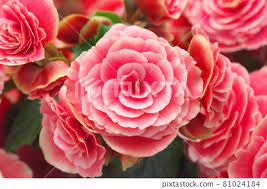

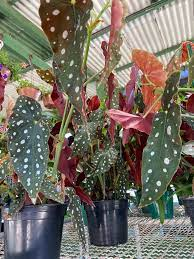

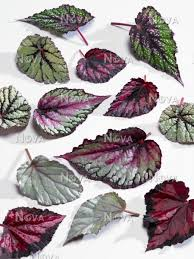

In [21]:
from  IPython.display import Image 
for classe in indice_para_classe.values():
    pasta_classe = os.path.join(pasta_treino, classe)
    arquivo_imagem = os.listdir(pasta_classe)[2]
    img = Image(filename=os.path.join(pasta_classe, arquivo_imagem))
    display(img)

In [22]:
alexnet = models.alexnet(weights='AlexNet_Weights.IMAGENET1K_V1')
alexnet


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [23]:
type(alexnet)

torchvision.models.alexnet.AlexNet

In [24]:
#Travando a rede neural
for param in alexnet.parameters():
    param.requires_grad = False

In [25]:
alexnet.classifier[6]

Linear(in_features=4096, out_features=1000, bias=True)

In [26]:
alexnet.classifier[6] = nn.Linear(4096, numero_de_classes)

alexnet.classifier.add_module("7", nn.LogSoftmax(dim = 1))


In [27]:
alexnet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [28]:
alexnet.classifier[6]

Linear(in_features=4096, out_features=3, bias=True)

In [29]:
parametros_ultima_camada = alexnet.classifier[6].parameters()

[parametro for parametro in parametros_ultima_camada][0].requires_grad

True

In [30]:
funcao_erro = nn.CrossEntropyLoss()

## <a> Otimizador <a/>
Otimizador, um feiticeiro poderoso que utiliza algoritmos para guiar a rede na busca pelos melhores parâmetros. 

## <a> Treinar e Validar <a/>
O treinamento realiza vários caminhos para frente (forward: previsão), cálculos de erro (distância entre previsão e valor real) e backward (backpropagation: aprendizado com o erro). A cada época, todas as imagens do treino são utilizadas para otimizar os parâmetros da rede. Dentro de cada época, utilizamos o treinamento em batch, ao invés de realizar o treinamento imagem por imagem.
Na validação, lembrar que não queremos manter o cálculo de gradientes, pois não vamos realizar o backpropagation.

In [31]:
otimizador = optim.Adam(alexnet.parameters())
otimizador

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)

In [32]:
def treinar_e_validar(modelo, metrica_erro, otimizador, epocas=10):
  

    historico = []
    melhor_acuracia = 0.0
    melhor_modelo = None
    

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)
    

    for epoca in range(epocas):
        inicio_epoca = time.time()
        print("\n\nÉpoca: {}/{}".format(epoca+1, epocas))
        
        # Erro e acurácia de validação nessa época
        erro_treino = 0.0
        acertos_treino = 0.0
        
    
        erro_validacao = 0.0
        acertos_validacao = 0.0
        
        # Interação com cada lote 
        for i, (imagens_lote, y_reais) in enumerate(data_loader_treino):
            print(f"\nLote: {i+1}\n")
            
    
            imagens_lote = imagens_lote.to(device)
            y_reais = y_reais.to(device)
            
            # Limpando grad
            otimizador.zero_grad()

            #Lote contém 8 imagens, serão 8 previsões 
            previsoes = modelo(imagens_lote)
     
        
            print(imagens_lote.size())
            print(previsoes)
            print(torch.exp(previsoes)) 
            print(torch.max(previsoes.data, 1))
            print(y_reais)


            # imagens do batch
            for indice in range(len(imagens_lote)):
                tensor_para_imagem = transforms.ToPILImage()
                imagem = tensor_para_imagem(imagens_lote[indice])
                display(imagem)
                
    
            
            erro = metrica_erro(previsoes, y_reais)
           
          
            erro.backward()
            
            
            otimizador.step()
            
            
            erro_treino += erro.item() * imagens_lote.size(0)
            
            
            _, classes_previstas = torch.max(previsoes.data, 1)
            predicoes_corretas = (classes_previstas == y_reais).type(torch.FloatTensor)
            
           
            acertos = torch.mean(predicoes_corretas)
            
            
            acertos_treino += torch.sum(predicoes_corretas)
            
           
        with torch.no_grad():

            
            modelo.eval()

            # Iteração de validação
            for j, (imagens_lote, y_reais) in enumerate(data_loader_validacao):
                imagens_lote = imagens_lote.to(device)
                y_reais = y_reais.to(device)

               
               
                previsoes = modelo(imagens_lote)

                
                erro = metrica_erro(previsoes, y_reais)

               
                erro_validacao += erro.item() * imagens_lote.size(0)

                
                _, classes_previstas = torch.max(previsoes.data, 1)
                predicoes_corretas = (classes_previstas == y_reais).type(torch.FloatTensor)

                
                acertos = torch.mean(predicoes_corretas)

                acertos_validacao += torch.sum(predicoes_corretas)
        
       
        
        # Calcular a média de erro e acurácia no treino
        erro_medio_treino = erro_treino/num_imagens_treino
        acuracia_media_treino = acertos_treino/num_imagens_treino

        # Calcular a média de erro e acurácia na validação
        erro_medio_validacao = erro_validacao/num_imagens_validacao
        acuracia_media_validacao = acertos_validacao/num_imagens_validacao

        # Incluir no histórico os erros e acurácias méidas
        historico.append([erro_medio_treino, erro_medio_validacao, acuracia_media_treino, acuracia_media_validacao])
                
        fim_epoca = time.time()
    
        print("Época : {:03d}, Treino: Erro: {:.4f}, Acurácia: {:.4f}%, \n\t\tValidação : Erro : {:.4f}, Acurácia: {:.4f}%, Tempo: {:.4f}s".format(epoca+1, erro_medio_treino, acuracia_media_treino*100, erro_medio_validacao, acuracia_media_validacao*100, fim_epoca-inicio_epoca))
        
     
        # salva no melhor modelo e na melhor acurácia
        if acuracia_media_validacao > melhor_acuracia:
            melhor_acuracia = acuracia_media_validacao
            #torch.save(modelo, './modelos/melhor_modelo.pt')
            melhor_modelo = modelo

    return melhor_modelo, historico



In [33]:
indice_para_classe

{0: 'elatior', 1: 'maculata', 2: 'rex'}

In [34]:
numero_de_epocas = 10

In [ ]:
#Essa célula roda o número de Épocas com imagens dos lotes e mostra o cálculo do erro. 
#Não vou rodar pelo tamanho que ocupa no projeto 
modelo_treinado, historico = treinar_e_validar(alexnet, funcao_erro, otimizador, numero_de_epocas)

## <a> Histórico de treinamento e validação <a/>


In [36]:
historico

[[0.7465545613620732, 0.3520679697061756, tensor(0.7387), tensor(0.8214)],
 [0.09852278063614928, 0.17476830399495416, tensor(0.9730), tensor(0.9286)],
 [0.04780926267817818, 0.16780314115541323, tensor(0.9820), tensor(0.9286)],
 [0.01705264065704132, 0.2083410724465336, tensor(0.9955), tensor(0.8929)],
 [0.010677503134010712, 0.20533366248543775, tensor(1.), tensor(0.9286)],
 [0.005975484866900621, 0.2001546167635492, tensor(1.), tensor(0.9286)],
 [0.005171692420451625, 0.19966429378837347, tensor(1.), tensor(0.9286)],
 [0.004477615979487529, 0.20102293600627621, tensor(1.), tensor(0.9286)],
 [0.003979023744102813, 0.2002582542066063, tensor(1.), tensor(0.9286)],
 [0.0035008725087233893, 0.20613046145133143, tensor(1.), tensor(0.9286)]]

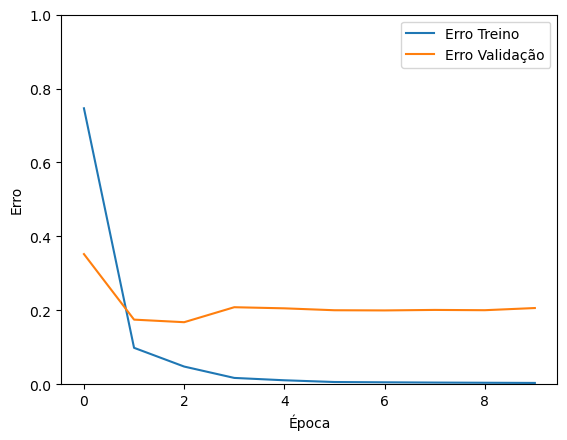

In [37]:
historico = np.array(historico)

plt.plot(historico[:,0:2])
plt.legend(['Erro Treino', 'Erro Validação'])
plt.xlabel('Época')
plt.ylabel('Erro')
plt.ylim(0,1)
plt.show()


## <a>Função de predição <a/>
Vamos criar a função para prever a classe de uma imagem com o melhor modelo treinado. Criaremos uma função que permitirá que nossa rede neural faça previsões de classe para uma imagem sem comprometer os gradientes ou os parâmetros do modelo.

In [38]:
indice_para_classe

{0: 'elatior', 1: 'maculata', 2: 'rex'}

In [39]:
def predicao_begonias(imagem_teste):
   
    transformacao = transformacoes_de_imagens['teste']
    
    tensor_imagem_teste = transformacao(imagem_teste)

    # Testa se voce é rico, ops, se tem uma placa NVIDIA :) (ou se instalou a versão certa do PyTorch)
    if torch.cuda.is_available():
        tensor_imagem_teste = tensor_imagem_teste.view(1, 3, image_size, image_size).cuda()
    else:
        tensor_imagem_teste = tensor_imagem_teste.view(1, 3, image_size, image_size)
    
    dict_predicoes = dict()
    
    # Não precisa calcular os gradientes com o autograd
    with torch.no_grad():
        modelo_treinado.eval()
        # Modelo retorna as probabilidades em log (log softmax)
        predicoes_log = modelo_treinado(tensor_imagem_teste)
        
        # torch.exp para voltar a probabilidade de log para a probabilidade linear
        predicoes = torch.exp(predicoes_log)
        
        dict_predicoes = {indice_para_classe[classe]: float(predicoes[0][classe]) for classe in range(numero_de_classes)}
        
        #print(dict_predicoes)
   
    return dict_predicoes

Previsão em imagens de teste¶
Não utilizamos as imagens de teste em nenhum lugar! Assim que aprendemos que deve ser e faremos para todo o sempre como bons e boas cientistas de dados.
Vamos fazer algumas previsões só para "brincar" e depois calculamos a acurácia.

In [40]:
pastas_begonias

['elatior', 'rex', 'maculata']

In [41]:
pasta_teste

'./data/processed/teste'

[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


'elatior'

'rex'

'maculata'

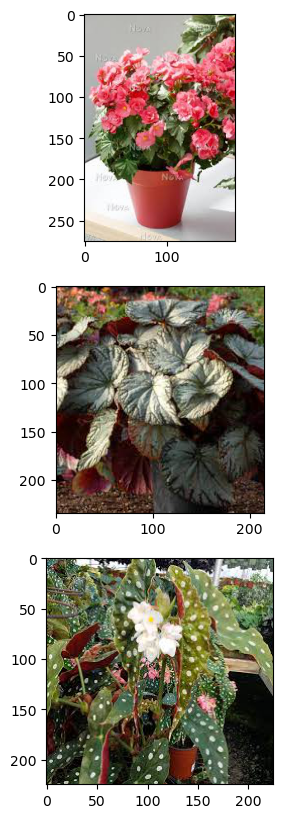

In [42]:
# Testando cada uma das classes
figura, plots = plt.subplots(nrows=numero_de_classes, ncols=1, figsize=(5, 10))

for indice, classe in enumerate(pastas_begonias):
    pasta_teste_classe = os.path.join(pasta_teste, classe)
    imagem = os.path.join(pasta_teste_classe, os.listdir(pasta_teste_classe)[2])
    imagem_teste = PIL.Image.open(imagem)

    plots[indice].imshow(imagem_teste)
    
    predicoes = predicao_begonias(imagem_teste)
    
    display(max(predicoes, key=predicoes.get))

In [43]:
def acuracia_teste(pasta_teste):
    acertos = 0
    total_imagens = 0
    
    for classe in os.listdir(pasta_teste):
        pasta_completa = os.path.join(pasta_teste, classe)
        total_imagens += len(os.listdir(pasta_completa))
        
        for imagem in os.listdir(pasta_completa):
            imagem = os.path.join(pasta_completa, imagem)
            imagem_teste = PIL.Image.open(imagem)
            predicoes = predicao_begonias(imagem_teste)
            predicao = max(predicoes, key=predicoes.get)

            if predicao == classe:
                acertos += 1
    
    return 100 * acertos/total_imagens

In [44]:
acuracia_teste(pasta_teste)

96.66666666666667

In [46]:
import gradio as gr

interface_gradio = gr.Interface(fn=predicao_begonias, 
                                inputs=gr.inputs.Image(type="pil"), 
                                outputs="label").launch(share=True)


/var/folders/vh/db3vg8dn33gb4jf4cn50gb480000gn/T/ipykernel_1253/3049849590.py:4: GradioDeprecationWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  inputs=gr.inputs.Image(type="pil"),
/var/folders/vh/db3vg8dn33gb4jf4cn50gb480000gn/T/ipykernel_1253/3049849590.py:4: GradioDeprecationWarning: `optional` parameter is deprecated, and it has no effect
  inputs=gr.inputs.Image(type="pil"),


Running on local URL:  http://127.0.0.1:7861


Traceback (most recent call last):
  File "/Users/vitoraugusto/opt/anaconda3/lib/python3.9/site-packages/gradio/routes.py", line 488, in run_predict
    output = await app.get_blocks().process_api(
  File "/Users/vitoraugusto/opt/anaconda3/lib/python3.9/site-packages/gradio/blocks.py", line 1431, in process_api
    result = await self.call_function(
  File "/Users/vitoraugusto/opt/anaconda3/lib/python3.9/site-packages/gradio/blocks.py", line 1109, in call_function
    prediction = await anyio.to_thread.run_sync(
  File "/Users/vitoraugusto/opt/anaconda3/lib/python3.9/site-packages/anyio/to_thread.py", line 28, in run_sync
    return await get_asynclib().run_sync_in_worker_thread(func, *args, cancellable=cancellable,
  File "/Users/vitoraugusto/opt/anaconda3/lib/python3.9/site-packages/anyio/_backends/_asyncio.py", line 818, in run_sync_in_worker_thread
    return await future
  File "/Users/vitoraugusto/opt/anaconda3/lib/python3.9/site-packages/anyio/_backends/_asyncio.py", line 754, i

Running on public URL: https://280c712c4d2d866047.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


Traceback (most recent call last):
  File "/Users/vitoraugusto/opt/anaconda3/lib/python3.9/site-packages/gradio/routes.py", line 488, in run_predict
    output = await app.get_blocks().process_api(
  File "/Users/vitoraugusto/opt/anaconda3/lib/python3.9/site-packages/gradio/blocks.py", line 1431, in process_api
    result = await self.call_function(
  File "/Users/vitoraugusto/opt/anaconda3/lib/python3.9/site-packages/gradio/blocks.py", line 1109, in call_function
    prediction = await anyio.to_thread.run_sync(
  File "/Users/vitoraugusto/opt/anaconda3/lib/python3.9/site-packages/anyio/to_thread.py", line 28, in run_sync
    return await get_asynclib().run_sync_in_worker_thread(func, *args, cancellable=cancellable,
  File "/Users/vitoraugusto/opt/anaconda3/lib/python3.9/site-packages/anyio/_backends/_asyncio.py", line 818, in run_sync_in_worker_thread
    return await future
  File "/Users/vitoraugusto/opt/anaconda3/lib/python3.9/site-packages/anyio/_backends/_asyncio.py", line 754, i

## <a> Conclusão <a> 
    

Em resumo, o desenvolvimento deste projeto de classificação de begônias utilizando uma rede neural representa um passo significativo em direção à aplicação prática do aprendizado de máquina em cenários diversos. Ao criar um modelo treinado com um conjunto diversificado de imagens das três espécies-alvo, conseguimos atingir uma notável acurácia de 96.6%. No decorrer deste projeto, além de destacar a eficácia do modelo, também enfatizamos a importância da precisão como um fator crucial para a viabilidade de implementações em diversos contextos.

Uma das principais contribuições desse projeto é a capacidade de fornecer autonomia para clientes sem conhecimento técnico profundo. Ao criar uma solução que se baseia em algoritmos de aprendizado de máquina, abrimos portas para que indivíduos de várias áreas possam utilizar essa ferramenta sem a necessidade de se tornarem especialistas em programação ou análise de dados. Isso promove a democratização da tecnologia e permite que empresas e pessoas de diferentes segmentos possam aproveitar os benefícios do aprendizado de máquina.

Além disso, a aplicabilidade prática se estende para a facilitação da demanda e a redução de filas. Com um modelo preciso em mãos, empresas que lidam com a classificação de begônias podem acelerar o processo de identificação das espécies, evitando atrasos e otimizando os fluxos de trabalho. Isso não apenas melhora a eficiência interna, mas também leva a uma melhor experiência para os clientes, que podem obter respostas e serviços mais rápidos.

A amplitude de aplicação do nosso modelo é impressionante, abrangendo diversos segmentos. Desde floriculturas e viveiros até laboratórios botânicos e centros de pesquisa ambiental, a capacidade de identificar rapidamente as espécies de begônias pode trazer vantagens significativas. Além disso, a estrutura e os princípios por trás desse projeto podem ser extrapolados para solucionar uma variedade de problemas, demonstrando o potencial abrangente da aplicação do aprendizado de máquina em contextos práticos.

Em adição a esses pontos, a nossa abordagem também sugere a possibilidade de reduzir custos operacionais, melhorar a eficiência de processos e aumentar a precisão em várias tarefas. Acreditamos que este projeto serve como um exemplo inspirador para as empresas que buscam soluções inovadoras para melhorar suas operações, oferecer um serviço de maior qualidade e maximizar seus recursos.

Em última análise, a aplicação bem-sucedida do aprendizado de máquina na classificação de begônias não apenas ressalta a capacidade tecnológica, mas também ilustra como a colaboração entre ciência de dados, botânica e negócios pode criar sinergias poderosas. Através desse projeto, abrimos novas perspectivas para a interseção entre tecnologia e natureza, pavimentando o caminho para futuras inovações em diversos setores.

    

![Rex](images/begoniarexpat.png)

![Maculata](images/maculatapat.jpeg)



![Elatior](images/elatiorpat.jpeg)